# <center>Тема 9. Анализ временных рядов в Python</center>
## <center>Часть 1. Главная</center>

Модели прогнозирования временного ряда на основе данных из Google Trends для демографических исследований

In [5]:
!pip install plotly

  Stored in directory: C:\Users\Evgeny\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying


In [6]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
# from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

Выгрузка для запросов "Беременность" и "Аборт" по данным Google Trends.
Регионы:
- г.Москва
- Московская область
- Краснодарский край
- г. Санкт-Петербург
- Свердловская область
- Ростовская область
- Республика Башкортостан
- Республика Татарстан

In [15]:
# dataset = pd.read_csv('../../data/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
dataset = pd.read_csv('D:/YaDisk/Sinchronization/YandexDisk/PROJECTS/[MSU] Demography/PY/DataSet_1_google_pop_reg.csv', sep=';', index_col=['Месяц'], parse_dates=['Месяц'])
# D:\YaDisk\Sinchronization\YandexDisk\PROJECTS\[MSU] Demography\PY
plotly_df(dataset, title = "Временные ряды для 8 регионов по запросам \"Аборт\" и \"Беременность\"")

### Примечание: так как до 2011 года выгрузка содержит недостоверные сведения (выбросы) по причине малого количества пользователей (заметны быстро нарастающие и спадающие пики внимания к теме), то датасет нужно урезать и рассматривать временной ряд с 2011 года

In [26]:
# Урезанный датасет с 2011 по 2020
dataset_2010_2020 = dataset[24:] # смещение на год соотвтествует 12 единицам
# Визуализация урезанного датасета
plotly_df(dataset_2010_2020, title = "Временные ряды для 8 регионов по запросам \"Аборт\" и \"Беременность\", 2011 - 2020")

In [41]:
# Замена названий колонок
col_names = {    
    "Беременность: (город Москва)": "Brm_Msc",
    "Беременность: (Московская область)": "Brm_Msc_obl",
    "Беременность: (Краснодарский край)": "Brm_Krsnodar",
    "Беременность: (город Санкт-Петербург)": "Brm_Spb",
    "Беременность: (Свердловская область)": "Brm_Sverdlovsk",
    "Беременность: (Ростовская область)": "Brm_Rostov",
    "Беременность: (Республика Башкортостан)": "Brm_Bash",
    "Беременность: (Республика Татарстан)": "Brm_Tatarstan"
}
# Выборка после преобразования
dataset_2011_2020_brm = dataset_2010_2020[dataset_2010_2020.columns[:8]].rename(columns=col_names)

dataset_2011_2020_brm.tail(10)

,Brm_Msc,Brm_Msc_obl,Brm_Krsnodar,Brm_Spb,Brm_Sverdlovsk,Brm_Rostov,Brm_Bash,Brm_Tatarstan
Месяц,,,,,,,,
2019-09-01,59,60,55,55,65,51,51,66
2019-10-01,60,60,55,54,61,54,56,65
2019-11-01,61,62,57,57,63,50,56,68
2019-12-01,60,64,53,55,63,55,56,64
2020-01-01,64,67,59,60,70,61,65,68
2020-02-01,49,55,50,49,48,49,49,58
2020-03-01,42,43,42,40,41,40,36,47
2020-04-01,58,53,52,55,53,51,47,56
2020-05-01,58,57,53,60,55,53,48,61


Для начала предположим - "завтра будет, как вчера", но вместо модели вида $\hat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений (в данном случае можно тестировать варианты: n = 1 "месяц назад", n = 12 "год назад", n = 6 "полгода назад" и т.д.), т.е. воспользуемся скользящим средним. 

$\hat{y}_{t} = \frac{1}{k} \displaystyle\sum^{k-1}_{n=0} y_{t-n}$

In [44]:
def moving_average(series, n):
    return np.average(series[-n:])

# Построение прогнозов скользящим средним по последнему месяцу, по 6 месяцам и году
for name in dataset_2011_2020_brm.columns:
    forecast_1 = moving_average(dataset_2011_2020_brm[name], 1) # прогноз, построенный по последнему наблюдаемому месяцу ( n = 1, т.к. данные по месяцам)
    forecast_6 = moving_average(dataset_2011_2020_brm[name], 6)
    forecast_12 = moving_average(dataset_2011_2020_brm[name], 12)
    print('+++++++++++++++++++++++++++++++++++++++++++++')
    print("Прогноз для {}".format(name))
    print("1 месяц - {}, 6 месяцев - {}, 12 месяцев - {}".format(forecast_1, forecast_6, forecast_12))

+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Msc
1 месяц - 61.0, 6 месяцев - 55.333333333333336, 12 месяцев - 58.5
+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Msc_obl
1 месяц - 56.0, 6 месяцев - 55.166666666666664, 12 месяцев - 58.916666666666664
+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Krsnodar
1 месяц - 55.0, 6 месяцев - 51.833333333333336, 12 месяцев - 53.666666666666664
+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Spb
1 месяц - 60.0, 6 месяцев - 54.0, 12 месяцев - 55.333333333333336
+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Sverdlovsk
1 месяц - 56.0, 6 месяцев - 53.833333333333336, 12 месяцев - 58.75
+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Rostov
1 месяц - 54.0, 6 месяцев - 51.333333333333336, 12 месяцев - 52.75
+++++++++++++++++++++++++++++++++++++++++++++
Прогноз для Brm_Bash
1 месяц - 53.0, 6 месяцев - 49.666666666666664, 12 месяцев - 52.166666666666664
++++++++++++

Для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше ширина интервала, тем более сглаженным окажется тренд. Если данные сильно зашумлены такая процедура может помочь увидеть общие паттерны.

In [52]:
def plotMovingAverage(series, n, plot_bounds=False):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """
    
    rolling_mean = series.rolling(window=n).mean()
        
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std =  series.rolling(window=n).std()
        upper_bound = rolling_mean+1.96*rolling_std
        lower_bound = rolling_mean-1.96*rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    # Деления соответствуют понедельникам что дает представление о недельной цикличности графика
    #ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    # Отображать значение дат в формате yy-mm-dd
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'));
    plt.xticks(rotation=45)

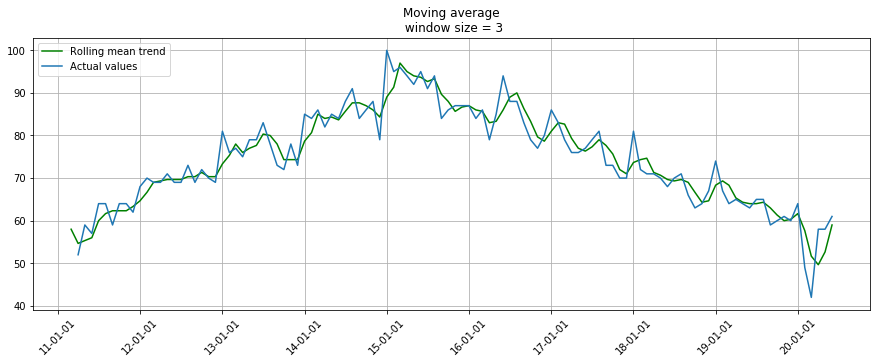

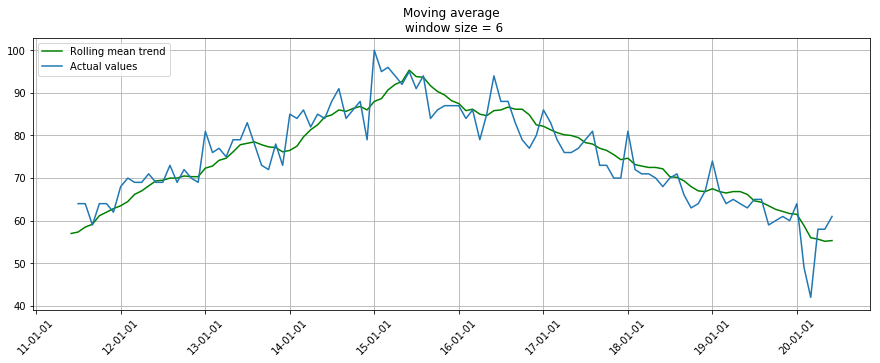

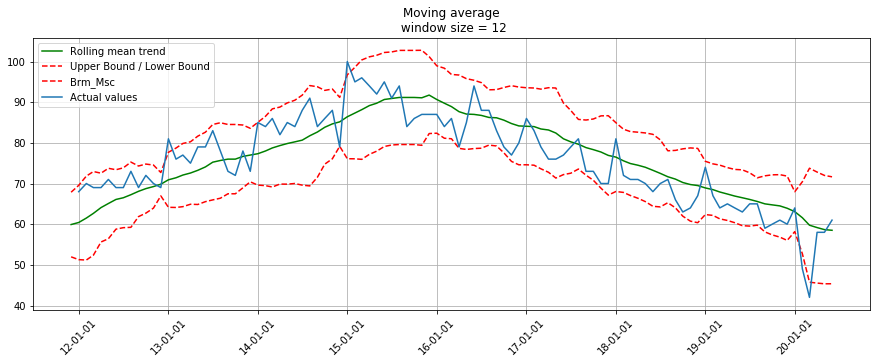

In [54]:
# Пример для Москвы
plotMovingAverage(dataset_2011_2020_brm.Brm_Msc, 3) # сглаживаем по полугодовым промежуткам
plotMovingAverage(dataset_2011_2020_brm.Brm_Msc, 6) # сглаживаем по полугодовым промежуткам
plotMovingAverage(dataset_2011_2020_brm.Brm_Msc, 12, plot_bounds=True) # сглаживание по году

*Можно обратить внимание*: при сглаживании по 3 и 6 месяцам можно наблюдать циклические колебания в запросах с сезонным минимумом в конце года (новогодние праздники)


Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 


$\hat{y}_{t} = \displaystyle\sum^{k}_{n=1} \omega_n y_{t+1-n}$

In [56]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

In [59]:
# Варианты с разными весами: 5 месяцев
print(weighted_average(dataset_2011_2020_brm.Brm_Msc, [0.6, 0.2, 0.1, 0.07, 0.03]))
#
print(weighted_average(dataset_2011_2020_brm.Brm_Msc, [0.45, 0.25, 0.15, 0.1, 0.03, 0.02]))

49.49
56.11


## Экспоненциальное сглаживание

Вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. По формуле простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$$\hat{y}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t-1} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [60]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

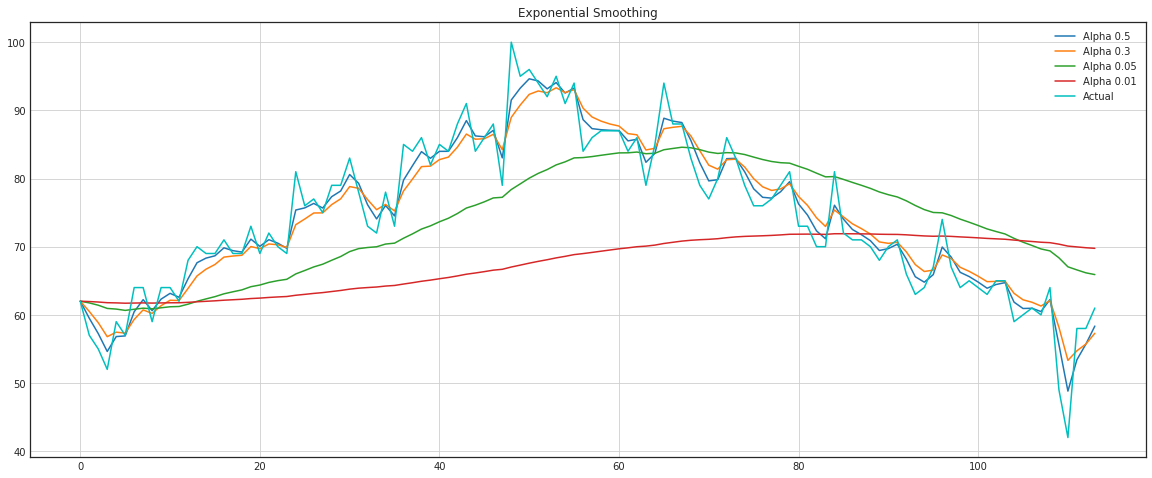

In [64]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.5, 0.3, 0.05, 0.01]:
        plt.plot(exponential_smoothing(dataset_2011_2020_brm.Brm_Msc, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset_2011_2020_brm.Brm_Msc.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и сгладить ряд). Стоит перейти к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на две точки вперед.

Нам необходимо разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$\ell_x = \alpha y_x + (1-\alpha)(\ell_{x-1} + b_{x-1})$

$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$\hat{y}_{x+1} = \ell_x + b_x$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

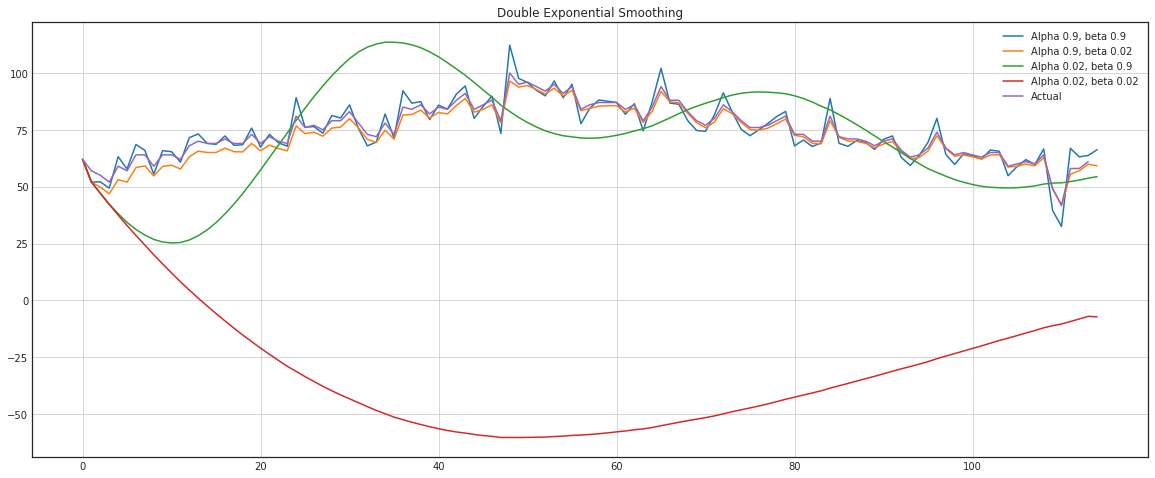

In [74]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result


with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset_2011_2020_brm.Brm_Msc, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset_2011_2020_brm.Brm_Msc.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [72]:
dataset_2011_2020_brm.Brm_Msc.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='Месяц', length=114, freq=None)

Теперь в модели два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. 

## Тройное экспоненциальное сглаживание a.k.a. Holt-Winters

Идея метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью обладает, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 12 (например, годовая сезонность), то получим 12 сезонных компонент, по одной на каждый из месяцев года.

Получаем новую систему:

$\ell_x = \alpha(y_x - s_{x-L}) + (1-\alpha)(\ell_{x-1} + b_{x-1})$


$b_x = \beta(\ell_x - \ell_{x-1}) + (1-\beta)b_{x-1}$

$s_x = \gamma(y_x - \ell_x) + (1-\gamma)s_{x-L}$

$\hat{y}_{x+m} = \ell_x + mb_x + s_{x-L+1+(m-1)modL}$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за январь, от и усредняться она будет только с другими январям. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд. 

Ниже приведен код для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$\hat y_{max_x}=\ell_{x−1}+b_{x−1}+s_{x−T}+m⋅d_{t−T}$

$\hat y_{min_x}=\ell_{x−1}+b_{x−1}+s_{x−T}-m⋅d_{t−T}$

$d_t=\gamma∣y_t−\hat y_t∣+(1−\gamma)d_{t−T}$,

где $T$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживани. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [76]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])
            
            
        

## Кросс-валидация на временных рядах

Необходимо выбрать подходящуюю для данной задачи функцию потерь: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error), [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) и др., которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и опускаться в сторону глобального минимума ошибки. 

Небольшая загвоздка возникает только в кросс-валидации. Проблема состоит в том, что временной ряд имеет, как ни парадоксально, временную структуру, и случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection)предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Код для кросс-валидации на временном ряду. Значение длины сезона 12 возникло не случайно - в исходном ряде отчетливо видна годовая сезонность.

In [93]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 12, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров - каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае - Truncated Newton conjugate gradient.

In [103]:
#%%time
data = dataset_2011_2020_brm.Brm_Msc[:-12] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.04625782423343844 0.16990600323607968 0.3530677628575622


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 6 месяцев вперед

In [108]:
# Передаем оптимальные значения модели, предсказание на 12 месяцев вперед
data = dataset_2011_2020_brm.Brm_Msc
model = HoltWinters(data[:-12], slen = 12, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 12, scaling_factor = 2.56)
model.triple_exponential_smoothing()

In [104]:
alpha_final

0.04625782423343844

Код для отрисовки графика

In [109]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

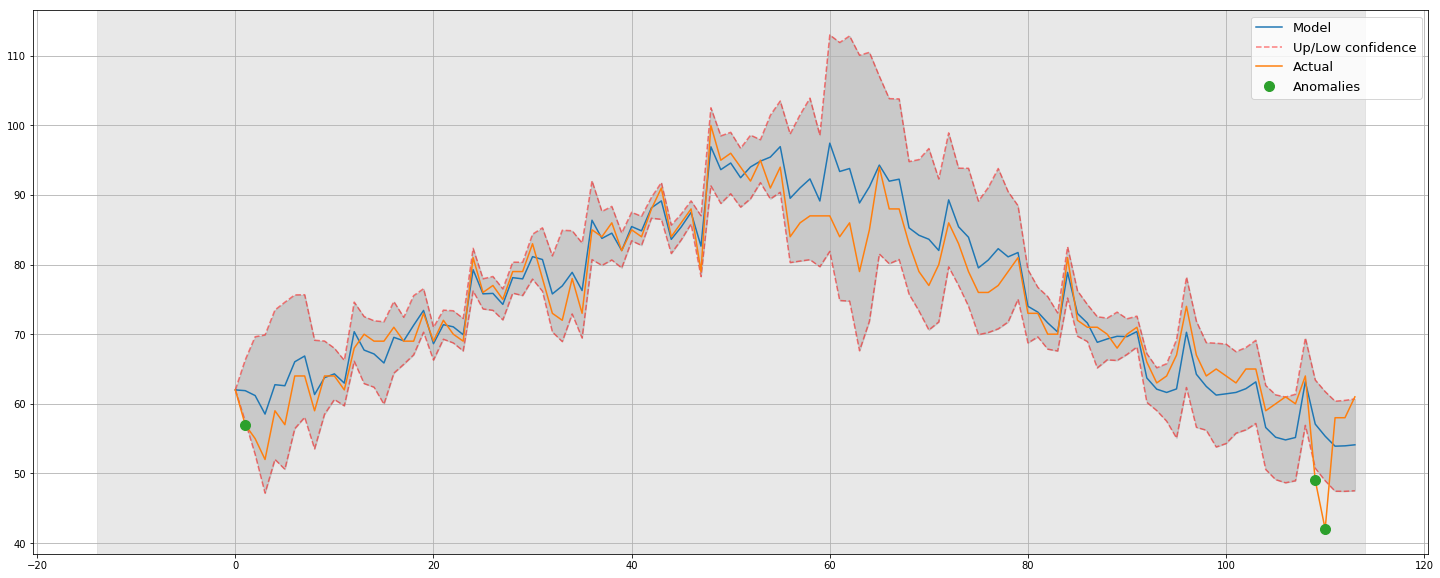

In [110]:
plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив годовую сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов (отчасти). Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

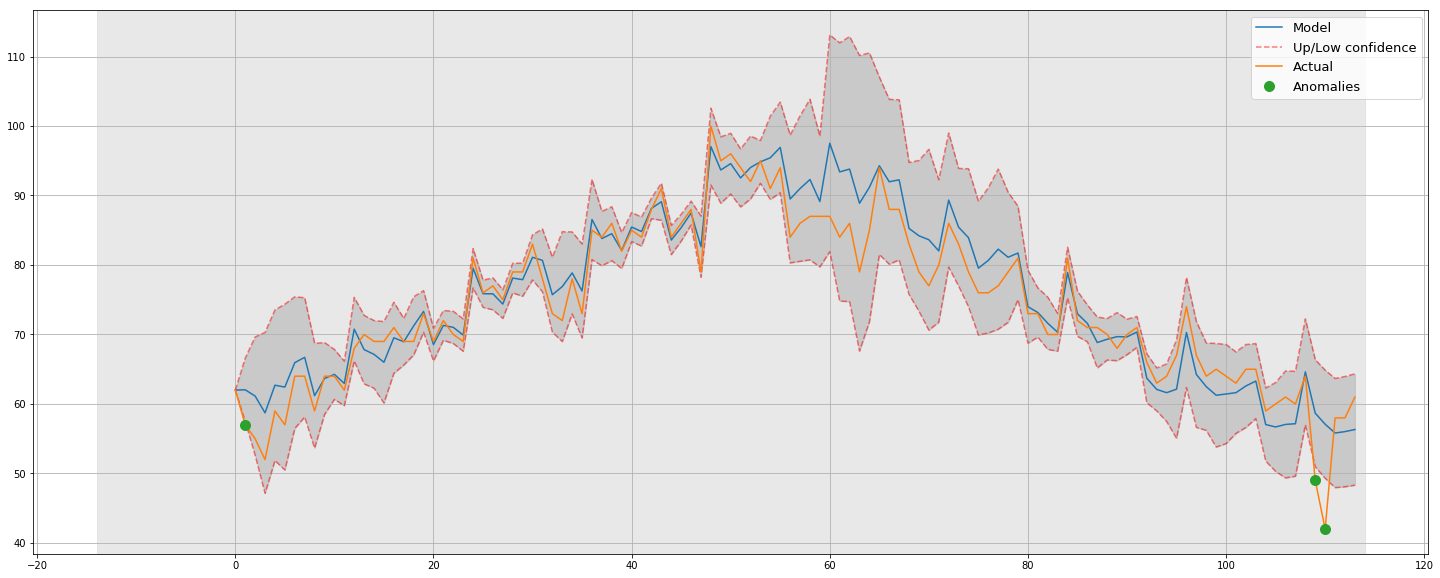

In [111]:
# Передаем оптимальные значения модели, предсказание на 12 месяцев вперед
data = dataset_2011_2020_brm.Brm_Msc
model = HoltWinters(data[:-6], slen = 12, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 6, scaling_factor = 2.56)
model.triple_exponential_smoothing()

plotHoltWinters()

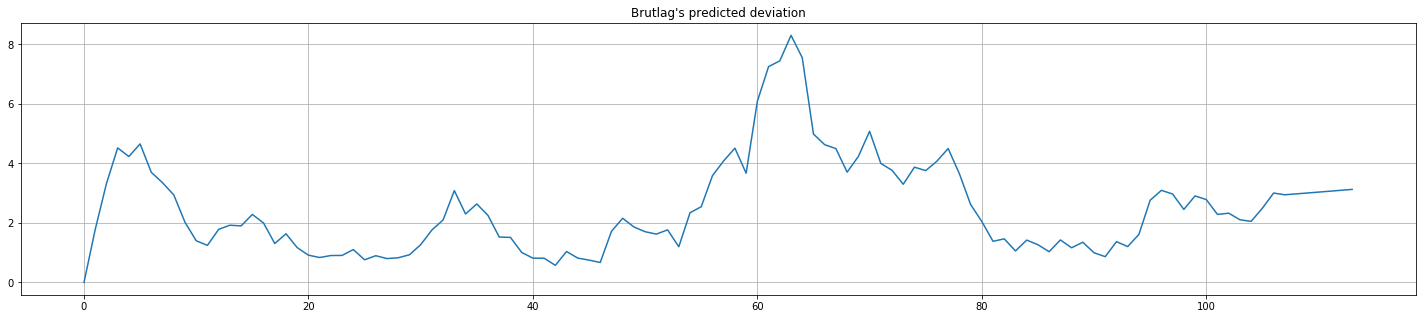

In [112]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# Эконометрический подход

График белого шума:

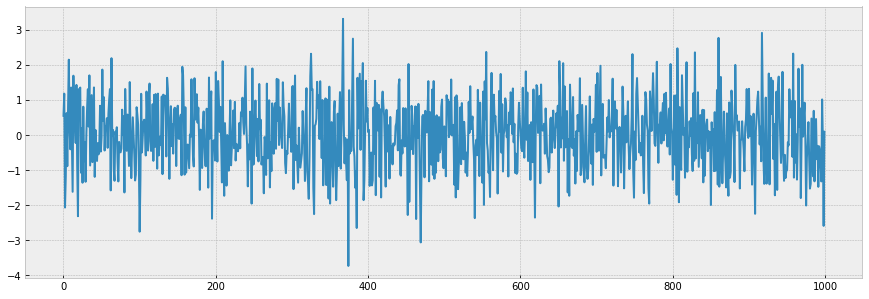

In [113]:
white_noise = np.random.normal(size=1000)
with plt.style.context('bmh'):  
    plt.figure(figsize=(15, 5))
    plt.plot(white_noise)

Итак, процесс, порожденный стандартным нормальным распределением, стационарен, колеблется вокруг нуля с отклонением в 1. Теперь на его основе сгенерируем новый процесс, в котором каждое последующее значение будет зависеть от предыдущего: $x_t = \rho x_{t-1} + e_t$ 

Код для отрисовки графиков

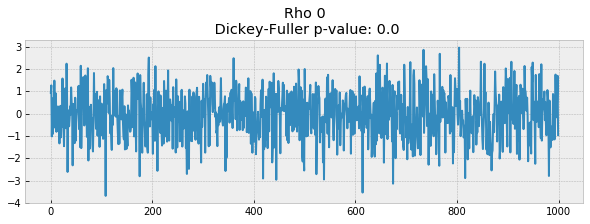

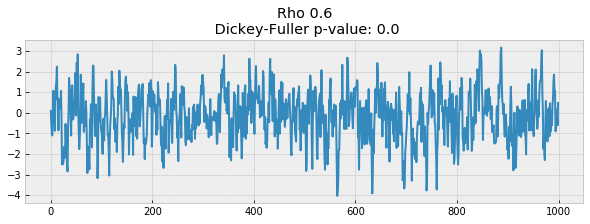

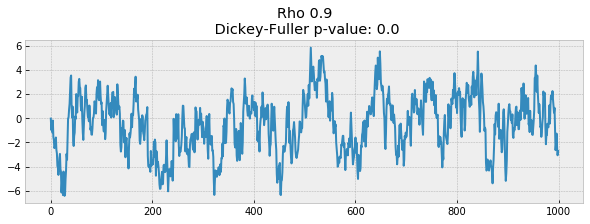

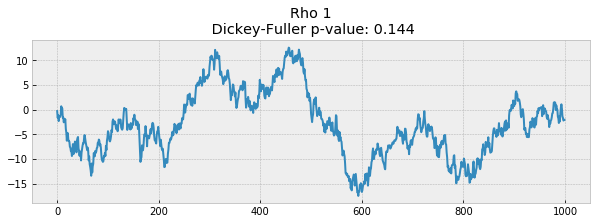

In [114]:
def plotProcess(n_samples=1000, rho=0):
    x = w = np.random.normal(size=n_samples)
    for t in range(n_samples):
        x[t] = rho * x[t-1] + w[t]

    with plt.style.context('bmh'):  
        plt.figure(figsize=(10, 3))
        plt.plot(x)
        plt.title("Rho {}\n Dickey-Fuller p-value: {}".format(rho, round(sm.tsa.stattools.adfuller(x)[1], 3)))
        
for rho in [0, 0.6, 0.9, 1]:
    plotProcess(rho=rho)

На первом графике получился точно такой же стационарный белый шум, который строился раньше. На втором значение $\rho$ увеличилось до 0.6, в результате чего на графике стали появляться более широкие циклы, но в целом стационарным он быть пока не перестал. Третий график всё сильнее отклоняется от нулевого среднего значения, но всё ещё колеблется вокруг него. Наконец, значение $\rho$ равное единице дало процесс случайного блуждания - ряд не стационарен.

Происходит это из-за того, что при достижении критической единицы, ряд $x_t = \rho x_{t-1} + e_t$ перестаёт возвращаться к своему среднему значению. Если вычесть из левой и правой части $x_{t-1}$, то получим $x_t - x_{t-1} = (\rho - 1) x_{t-1} + e_t$, где выражение слева - первые разности. Если $\rho=1$, то первые разности дадут стационарный белый шум $e_t$. Этот факт лёг в основу теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/Тест_Дики_—_Фуллера) на стационарность ряда (наличие единичного корня). Если из нестационарного ряда первыми разностями удаётся получить стационарный, то он называется интегрированным первого порядка.
Нулевая гипотеза - ряд не стационарен, отвергалась на первых трех графиках, и принялась на последнем. Стоит сказать, что не всегда для получения стационарного ряда хватает первых разностей, так как процесс может быть интегрированным с более высоким порядком (иметь несколько единичных корней), для проверки таких случаев используют расширенный тест Дики-Фуллера, проверяющий сразу несколько лагов.

Бороться с нестационарностью можно множеством способов - разностями различного порядка, выделением тренда и сезонности, сглаживаниями и преобразованиями, например, Бокса-Кокса или логарифмированием.

## Избавляемся от нестационарности и строим SARIMA

Попробуем теперь построить ARIMA модель для запросов. Про саму модель писали на хабре - [Построение модели SARIMA с помощью Python+R](https://habrahabr.ru/post/210530/), [Анализ временных рядов с помощью python](https://habrahabr.ru/post/207160/).

Код для отрисовки графиков

In [115]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])


        plt.tight_layout()
    return 

Критерий Дики-Фуллера: p=0.753700


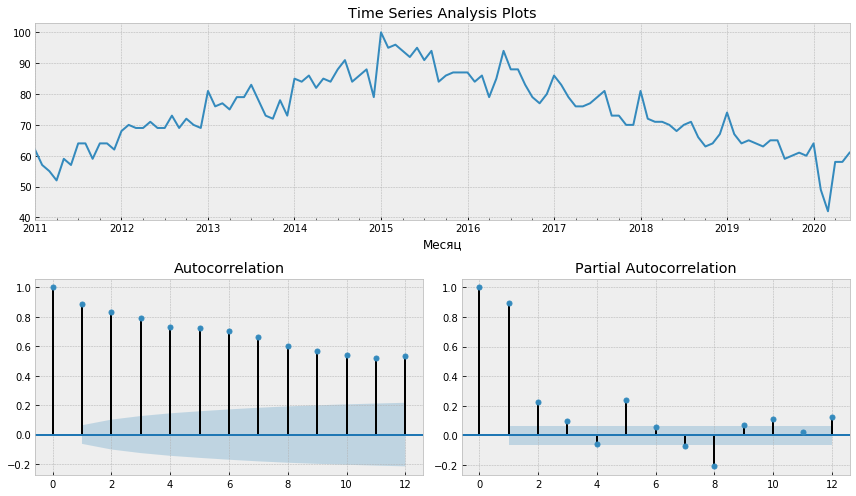

In [122]:
tsplot(dataset_2011_2020_brm.Brm_Msc, lags=12)

Как и следовало ожидать, исходный ряд стационарным не является, критерий Дики-Фуллера не отверг нулевую гипотезу о наличии единичного корня. Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса

Критерий Дики-Фуллера: p=0.753700
Оптимальный параметр преобразования Бокса-Кокса: 1.089434


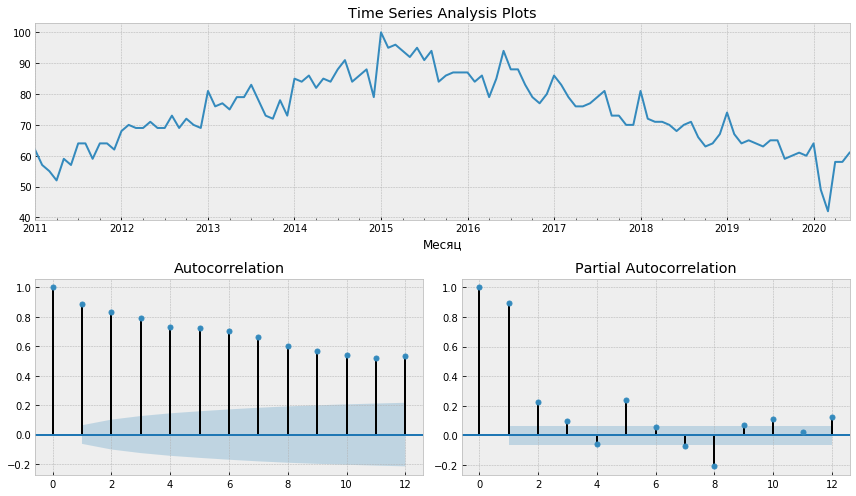

In [123]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))


data = dataset_2011_2020_brm.copy()
data['Brm_Msc_BC'], lmbda = scs.boxcox(data.Brm_Msc+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.Brm_Msc, lags=12)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Уже лучше, однако критерий Дики-Фуллера по-прежнему не отвергает гипотезу о нестационарности ряда. 

Критерий Дики-Фуллера: p=0.726823


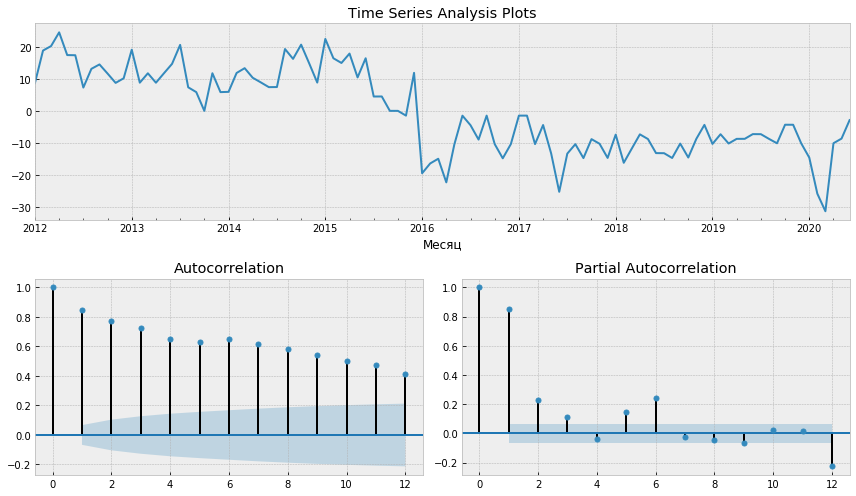

In [126]:
data['Brm_Msc_BC_season'] = data.Brm_Msc_BC - data.Brm_Msc_BC.shift(12)
tsplot(data.Brm_Msc_BC_season[12:], lags=12)

Критерий Дики-Фуллера пока не отвергает нулевую гипотезу о нестационарности и автокорреляционная функция всё ещё выглядит нехорошо из-за большого числа значимых лагов. Стоит взять еще первые разности, чтобы привести, наконец, ряд к стационарному виду.

Критерий Дики-Фуллера: p=0.002622


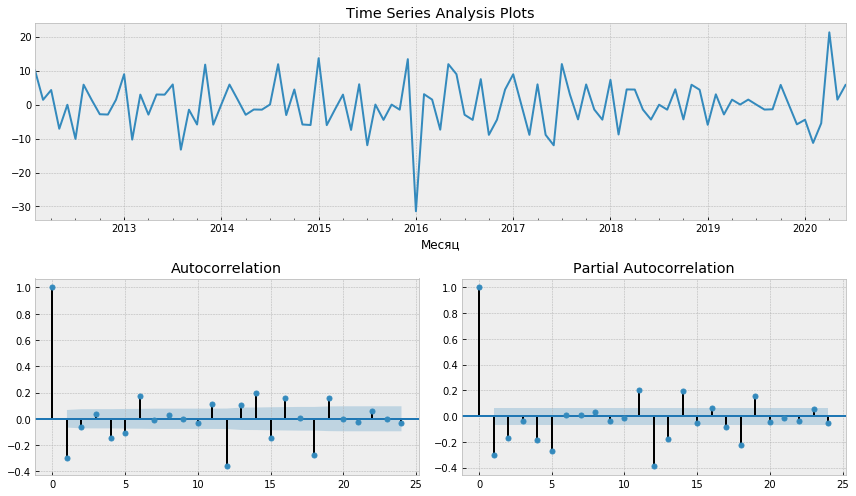

In [129]:
data['Brm_Msc_BC_season_diff'] = data.Brm_Msc_BC_season - data.Brm_Msc_BC_season.shift(1)
tsplot(data.Brm_Msc_BC_season_diff[12+1:], lags=24)

Наконец, получили стационарный ряд, по автокорреляционной и частной автокорреляционной функции прикинем параметры для SARIMA модели, на забыв, что предварительно уже сделали первые и сезонные разности.

In [138]:
# Вторые разности под вопросом
#data['Brm_Msc_BC_season_diff_diff'] = data.Brm_Msc_BC_season_diff - data.Brm_Msc_BC_season_diff.shift(1)
#tsplot(data.Brm_Msc_BC_season_diff_diff[12+1:], lags=6)

К определению параметра D. 

Он определет порядок интегрированности сезонной разности, т.е. в нашем случае он равен 1. Для определения P и Q нам нужно построить коррелограммы ACF и PACF.

Начальные приближения Q = 1, P = 4, q = 3, p = 4

In [142]:
ps = range(0, 5)
d=1
qs = range(0, 4)
Ps = range(0, 12)
D=1
Qs = range(0, 13)

from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

3120

In [164]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Brm_Msc_BC, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[3], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
523  (3, 3, 6, 1)  656.106295
520  (3, 3, 5, 1)  656.106295
517  (3, 3, 4, 1)  656.106295
514  (3, 3, 3, 1)  656.106295
511  (3, 3, 2, 1)  656.106295
Wall time: 8min 15s


Лучшие параметры передаем в модель:

In [174]:
#%%time
best_model=sm.tsa.statespace.SARIMAX(data.Brm_Msc_BC, order=(3, d, 3), 
                                        seasonal_order=(2, D, 1, 12)).fit(disp=-1)

best_model

In [175]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         Brm_Msc_BC   No. Observations:                  114
Model:             SARIMAX(3, 1, 3)x(2, 1, 1, 12)   Log Likelihood                -319.183
Date:                            Mon, 06 Jul 2020   AIC                            658.366
Time:                                    15:42:42   BIC                            684.518
Sample:                                01-01-2011   HQIC                           668.953
                                     - 06-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5697      0.188      3.034      0.002       0.202       0.938
ar.L2         -0.8492      0.139   

In [176]:
best_model

Проверим остатки модели:

Критерий Дики-Фуллера: p=0.000000


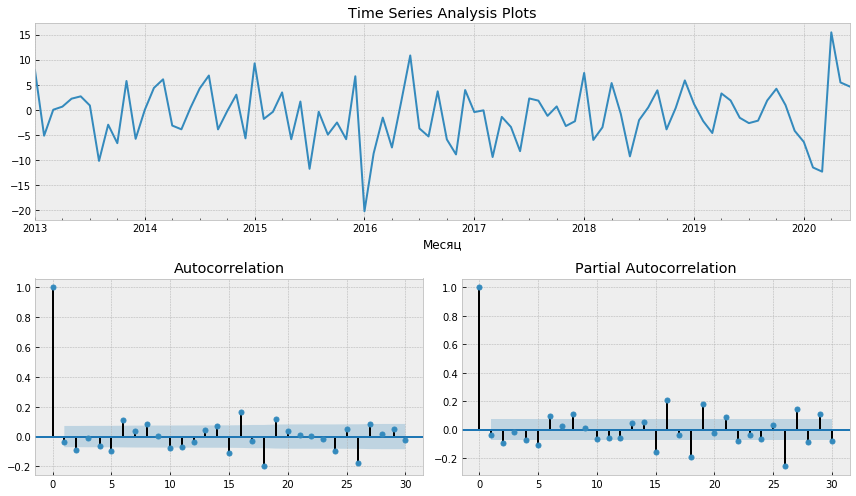

In [177]:
tsplot(best_model.resid[24:], lags=30)

остатки стационарны, явных автокорреляций нет, построим прогноз по получившейся модели

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning:

Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.



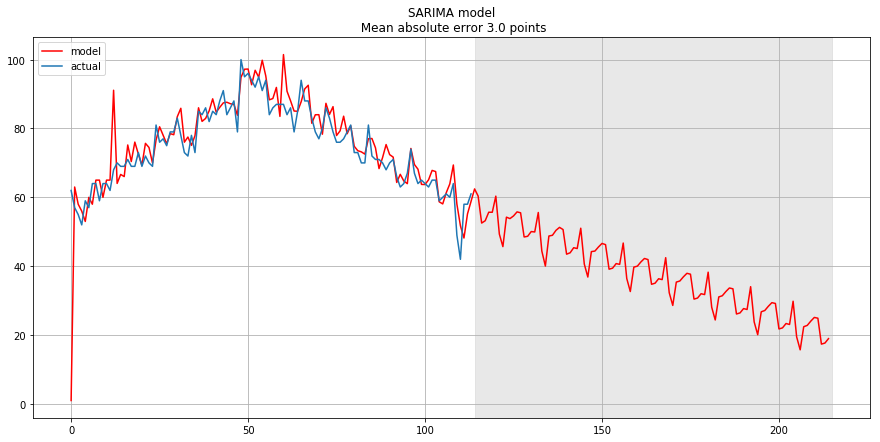

In [182]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Brm_Msc.values[-120:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} points".format(round(mean_absolute_error(data.dropna().Brm_Msc, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

В финале получаем достаточно адекватный прогноз, в среднем модель ошибалась на 3 единицы, что неплохо, однако суммарные затраты на подготовку данных, приведение к стационарности, определение и перебор параметров могут такой точности и не стоить.